# Issue Type Identification via Semantic Clustering

This notebook implements a semantic clustering pipeline to identify common types of issues, bugs, and vulnerabilities in the dataset.

**Methodology:**
1. **Data Aggregation**: Group data by commit to create a rich textual representation (Commit Message + Changed Files + Changed Methods).
2. **Embedding**: Use `all-MiniLM-L6-v2` (Sentence Transformers) to convert text to high-dimensional vectors.
3. **Dimensionality Reduction**: Apply UMAP to reduce noise and computational complexity.
4. **Clustering**: Use HDBSCAN (Density-based clustering) to find organic groups of similar commits.
5. **Interpretability**: Extract top TF-IDF terms and exemplar commits to label each cluster.
6. **Export**: Save statistics and plots for reporting.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings


warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## 1. Data Loading and Preprocessing

We load the largest available dataset (~1.1 GB csv) to get the most comprehensive view.

In [11]:
# Find the largest CSV file
data_dir = "../assets/data-samples/"
if not os.path.exists(data_dir): 
    # Fallback if running from a different root
    data_dir = "assets/data-samples/"

csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {data_dir}")

csv_files_sorted = sorted(csv_files, key=lambda x: os.path.getsize(os.path.join(data_dir, x)), reverse=True)

target_file = csv_files_sorted[0]
file_path = os.path.join(data_dir, target_file)
print(f"Loading largest dataset: {target_file} ({os.path.getsize(file_path) / (1024**2):.2f} MB)")

# Read only relevant columns to save memory
use_cols = ['project_name', 'commit_url', 'commit_message', 'file_path', 'method_name']
df = pd.read_csv(file_path, usecols=use_cols, dtype='string')

# Drop NA messages
df = df.dropna(subset=['commit_message'])
print(f"Loaded {len(df)} rows")

Loading largest dataset: job-113755.csv (1101.03 MB)
Loaded 602500 rows


### Grouping by Commit
Each row in the raw CSV is a file/method change. We need a single text block per commit to cluster effectively.

In [12]:
def aggregate_commit(x):
    # Unique files and methods
    files = list(set(f for f in x['file_path'] if pd.notna(f)))
    methods = list(set(m for m in x['method_name'] if pd.notna(m)))
    
    # Limit to top 5 files/methods to avoid super long texts
    files_str = ", ".join(files[:5])
    methods_str = ", ".join(methods[:5])
    
    msg = x['commit_message'].iloc[0]
    
    # Construct rich text
    # Format: "Log message | Files: A, B | Methods: X, Y"
    full_text = f"{msg} | Files: {files_str} | Methods: {methods_str}"
    
    return pd.Series({
        'project_name': x['project_name'].iloc[0],
        'commit_message': msg,
        'full_text': full_text,
        'n_files': len(files)
    })

# Grouping
print("Aggregating by commit...")
commits_df = (
    df.groupby('commit_url', group_keys=False)
    .apply(aggregate_commit, include_groups=False)
    .reset_index()
)
print(f"Total unique commits: {len(commits_df)}")

commits_df.head()

Aggregating by commit...
Total unique commits: 5785


,commit_url,project_name,commit_message,full_text,n_files
0,https://github.com/1mobilesuper/1mobile_download/commit/2cca22d83866f71013cd6cf52ba7c1bd013b799d,1mobilesuper/1mobile_download,1.0.1:fix notification,"1.0.1:fix notification | Files: src/me/onemobile/android/download/AppsStatusDBHelper.java, src/m...",18
1,https://github.com/ABrambleNinja/TicTacToe/commit/00d440cd1e625fc7ca8b771e5a097c3b51fa63d8,ABrambleNinja/TicTacToe,fixed 100 games,"fixed 100 games | Files: src/org/syntaxes/TicTacToe/TicTacToe.java | Methods: getUserMove, print...",1
2,https://github.com/ABrambleNinja/TicTacToe/commit/09db84dcee4e8fbd5fee1e4852c1225e8217e2da,ABrambleNinja/TicTacToe,fixed everything,"fixed everything | Files: src/org/syntaxes/TicTacToe/TicTacToe.java | Methods: getUserMove, prin...",1
3,https://github.com/ABrambleNinja/TicTacToe/commit/134f4b99af1c857d08f461a1e6530747a4f6d16e,ABrambleNinja/TicTacToe,working out bugs,"working out bugs | Files: src/org/syntaxes/TicTacToe/TicTacToe.java | Methods: getUserMove, prin...",1
4,https://github.com/ABrambleNinja/TicTacToe/commit/8421c63770960a87cd28236a87ae0f9808242ca9,ABrambleNinja/TicTacToe,fixed o not able to win,fixed o not able to win | Files: src/org/syntaxes/TicTacToe/TicTacToe.java | Methods: getUserMov...,1


## 2. Embedding Generation

Using `all-MiniLM-L6-v2` for efficient, high-quality sentence embeddings.

In [13]:
model_name = 'all-MiniLM-L6-v2'
print(f"Loading model {model_name}...")
model = SentenceTransformer(model_name)

# Generate embeddings
print("Encoding texts (this may take a while)...")
embeddings = model.encode(commits_df['full_text'].tolist(), show_progress_bar=True)

print(f"Embedding shape: {embeddings.shape}")

Loading model all-MiniLM-L6-v2...
Encoding texts (this may take a while)...


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Embedding shape: (5785, 384)


## 3. Dimensionality Reduction (UMAP)

We reduce the 384-dimensional embeddings to 5 dimensions to help HDBSCAN find dense clusters.

In [ ]:
umap_reducer = umap.UMAP(
    n_neighbors=15,
    n_components=50,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

print("Running UMAP reduction...")
umap_embeddings = umap_reducer.fit_transform(embeddings)
print("UMAP done.")

Running UMAP reduction...


## 4. Clustering (HDBSCAN)

Density-based clustering to identify topics.

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,      # Smallest size to consider a cluster
    min_samples=5,            # How conservative the clustering is
    metric='euclidean',
    cluster_selection_method='eom', # Excess of Mass
    prediction_data=True
)

print("Running HDBSCAN...")
cluster_labels = clusterer.fit_predict(umap_embeddings)
commits_df['cluster'] = cluster_labels

# -1 indicates noise
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Found {n_clusters} clusters.")
print(f"Noise points: {n_noise} ({n_noise/len(commits_df)*100:.1f}%)")

Running HDBSCAN...
Found 71 clusters.
Noise points: 790 (13.7%)


## 5. Cluster Analysis & Interpretation

We calculate TF-IDF scores for the `full_text` within each cluster to find representative keywords.

In [ ]:
def extract_top_tfidf_terms(df, cluster_col='cluster', text_col='full_text', top_n=6):
    # Treat each cluster as a single document
    valid_clusters = [c for c in df[cluster_col].unique() if c != -1]
    cluster_docs = []
    cluster_ids = []
    
    for c in valid_clusters:
        c_texts = df[df[cluster_col] == c][text_col].tolist()
        cluster_docs.append(" ".join(c_texts))
        cluster_ids.append(c)
        
    # Compute TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)
    tfidf_matrix = vectorizer.fit_transform(cluster_docs)
    feature_names = vectorizer.get_feature_names_out()
    
    results = {}
    for i, cluster_id in enumerate(cluster_ids):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[-top_n:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices]
        results[cluster_id] = ", ".join(top_terms)
        
    return results

print("Extracting top terms per cluster...")
top_terms_map = extract_top_tfidf_terms(commits_df)
print("Done.")

Extracting top terms per cluster...
Done.


### Generate Summary Table

In [ ]:
# Compute cluster stats
cluster_stats = commits_df['cluster'].value_counts().reset_index()
cluster_stats.columns = ['Cluster ID', 'Size']

# Filter out noise (-1)
cluster_stats = cluster_stats[cluster_stats['Cluster ID'] != -1]

# Map terms
cluster_stats['Top Terms'] = cluster_stats['Cluster ID'].map(top_terms_map)

# Sort by size
cluster_stats = cluster_stats.sort_values('Size', ascending=False).reset_index(drop=True)

# Add a placeholder for Manual Label
cluster_stats['Manual Label'] = ""

# Display top 20 clusters
pd.set_option('display.max_colwidth', 100)
display(cluster_stats.head(20))

# Save to CSV
output_dir = "../analysis"
if not os.path.exists(output_dir):
    output_dir = "analysis"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

,Cluster ID,Size,Top Terms,Manual Label
0,11,434,"jsf, jst, eclipse, org, plugins, facesconfig",
1,42,322,"ceylon, redhat, ceylondoc, tools, compiler, getresourceurl",
2,5,231,"i2cat, net, mantychore, manticore, bundles, svn",
3,29,220,"opennaas, router, extensions, org, core, bundles",
4,16,191,"red5, org, server, tomcat, net, api",
5,24,171,"red5, server, org, rtmp, net, codec",
6,14,153,"jst, pagedesigner, eclipse, jsf, org, plugins",
7,10,138,"vcpe, opennaas, extensions, org, bundles, main",
8,58,127,"calendar, month, android, view, day, id",
9,2,122,"calendar, android, alerts, notification, notifications, alertservice",


### Visualize Clusters (2D UMAP Projection)

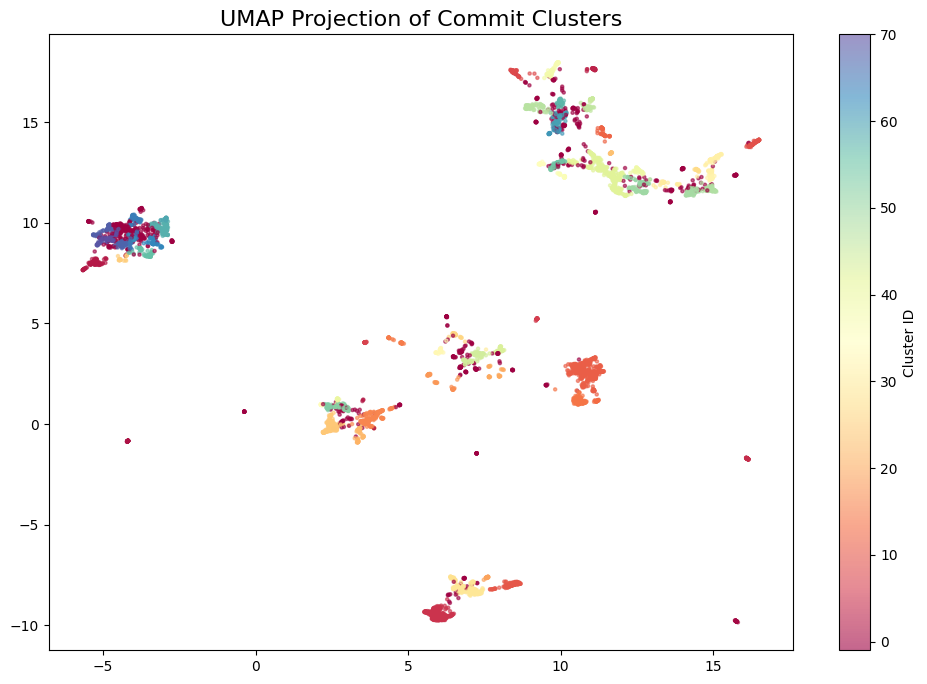

In [ ]:
# Project to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, random_state=42)
proj_2d = umap_2d.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    proj_2d[:, 0], 
    proj_2d[:, 1], 
    c=cluster_labels, 
    cmap='Spectral', 
    s=5,
    alpha=0.6
)
plt.title('UMAP Projection of Commit Clusters', fontsize=16)
plt.colorbar(scatter, label='Cluster ID')


plt.show()